In [1]:
import os
import pandas as pd
import numpy as np
import json
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
from zipline.utils.factory import load_bars_from_yahoo
import pytz
import talib
import numpy as np
from sklearn import model_selection
from sklearn import preprocessing
import matplotlib.pyplot as plt
import ystockquote

In [2]:
symbols = ['A', 'AA', 'AAP']#, 'ABBV', 'ABT', 'ACN', 'ADBE', 'AES', 'AET', 'AFL']
start = datetime(2000, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2016, 4, 30, 0, 0, 0, 0, pytz.utc)
dates = pd.date_range(start,end)

In [89]:
dates

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2016-04-21', '2016-04-22', '2016-04-23', '2016-04-24',
               '2016-04-25', '2016-04-26', '2016-04-27', '2016-04-28',
               '2016-04-29', '2016-04-30'],
              dtype='datetime64[ns, UTC]', length=5965, freq='D')

In [2]:
dates = pd.date_range('2011-10-13', '2016-10-12')
dates

DatetimeIndex(['2011-10-13', '2011-10-14', '2011-10-15', '2011-10-16',
               '2011-10-17', '2011-10-18', '2011-10-19', '2011-10-20',
               '2011-10-21', '2011-10-22',
               ...
               '2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06',
               '2016-10-07', '2016-10-08', '2016-10-09', '2016-10-10',
               '2016-10-11', '2016-10-12'],
              dtype='datetime64[ns]', length=1827, freq='D')

In [4]:
def get_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    data = []
    for symbol in symbols:
        df_temp = pd.read_csv(os.path.join("Data/table_{}.csv".format(str(symbol))), index_col='Date',
                              parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'])
        df_comp = pd.read_csv(os.path.join("Data/table_{}.csv".format(str(symbol))), index_col='Date',
                              parse_dates=True, na_values=['nan'])
        data.append(df_comp)
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        #print df_temp
        df = df.join(df_temp)
    return [df, data]

In [6]:
[df_old, data] = get_data(symbols, dates)

In [9]:
df_old.size/3

1827

In [127]:
df_old.isnull().values.any()

True

In [128]:
df_old.isnull().sum().sum()

1707

In [119]:
len(dates)

1827

In [452]:
def get_stocks_info(symbol):
    dict_stocks = ystockquote.get_historical_prices(symbol, '2006-10-13', '2016-12-12')
    json_str = json.dumps(dict_stocks)
    df =pd.read_json(json_str,orient='index')
    df = df.reindex(df.index.rename('Date'))
    return df

In [453]:
def fill_missing(df):
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

In [454]:
df = get_stocks_info('GOOGL')

In [455]:
ticker='GOOGL'

In [456]:
new_df = df.filter(['Date','Adj Close'], axis=1)

In [457]:
#new_df.isnull().values.any()

In [458]:
s = new_df.reindex(dates, fill_value=np.nan)
fill_missing(s)

In [459]:
#s.isnull().values.any()

In [460]:
#s.isnull().sum().sum()*3

In [461]:
s = s.reindex(s.index.rename('Date'))

In [462]:
s.head()

,Adj Close
Date,
2011-10-13,279.774784
2011-10-14,296.136143
2011-10-15,296.136143
2011-10-16,296.136143
2011-10-17,291.496494


In [463]:
def smavg(df, N):
    return pd.rolling_mean(df, N)[N - 1:]


def expmavg(df, span):
    return pd.ewma(df, span=span)


def com_daily_returns(df):
    daily_returns = (df / df.shift(1)) - 1
    return daily_returns


def com_momentum(df, n):
    mom = (df / df.shift(n))
    return mom


def com_rsi(df, n):
    df = df.diff()
    df = df[1:]
    up, down = df.copy(), df.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = pd.rolling_mean(up, n)
    roll_down = pd.rolling_mean(down.abs(), n)
    rs = roll_up / roll_down
    rss = 100.0 - (100.0 / (1.0 + rs))
    return rss

def BBW(data,length):
    return 4*pd.stats.moments.rolling_std(data,length)

def com_williamspercent(df):
    high=pd.rolling_max(df,2)
    low=pd.rolling_min(df,2)
    return ((high-df)/(high-low))*100

In [464]:
df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2006-10-13,213.863864,427.300000,429.500007,425.560012,427.760019,7237700
2006-10-16,211.086093,421.750013,429.200015,421.339993,427.700021,8630100
2006-10-17,210.530536,420.640010,423.749995,416.700015,420.300018,10411500
2006-10-18,209.864871,419.310012,424.750001,417.499995,422.990014,12022500
2006-10-19,213.243243,426.060000,429.500007,419.570006,420.230020,22983900


In [465]:
temp_df = s.copy()
comp_temp = df.copy()
volume = comp_temp['Volume']
high = comp_temp['High']
close = comp_temp['Close']
low = comp_temp['Low']
# print type(volume)
sum_data = temp_df.join(high)
sum_data =sum_data.join(close)
sum_data =sum_data.join(low)
sum_data =sum_data.join(volume)
fill_missing(sum_data)
sum_data = sum_data[['High','Low','Close','Volume']]
low = sum_data['Low']
high =sum_data['High']
volume = sum_data['Volume']
close = sum_data['Close']
sma10 = smavg(temp_df, 10)
print temp_df.head()
print sma10.head()
sma10 = sma10.rename(columns={'Adj Close':'sma10'})
print temp_df.head()
print sma10.head()
sma20 = smavg(temp_df, 20)
sma20 = sma20.rename(columns={'Adj Close':'sma20'})
sma30 = smavg(temp_df, 30)
sma30 = sma30.rename(columns={'Adj Close':'sma30'})
ema10 = expmavg(temp_df, 10)
ema10 = ema10.rename(columns={'Adj Close':'ema10'})
ema20 = expmavg(temp_df, 20)
ema20 = ema20.rename(columns={'Adj Close':'ema20'})
ema30 = expmavg(temp_df, 30)
ema30 = ema30.rename(columns={'Adj Close':'sma30'})
mom = com_momentum(temp_df, 10)
mom = mom.rename(columns={'Adj Close':'mom'})
drr = com_daily_returns(temp_df)
drr = drr.rename(columns={'Adj Close':'drr'})
bbw = BBW(temp_df, 20)
bbw = bbw.rename(columns={'Adj Close':'bbw'})
will = com_williamspercent(temp_df)
will = will.rename(columns={'Adj Close':'will'})
rsi = com_rsi(temp_df, 10)
rsi = rsi.rename(columns={'Adj Close':'rsi'})

             Adj Close
Date                  
2011-10-13  279.774784
2011-10-14  296.136143
2011-10-15  296.136143
2011-10-16  296.136143
2011-10-17  291.496494
             Adj Close
Date                  
2011-10-22  292.907911
2011-10-23  294.484486
2011-10-24  294.721723
2011-10-25  294.295295
2011-10-26  294.026526
             Adj Close
Date                  
2011-10-13  279.774784
2011-10-14  296.136143
2011-10-15  296.136143
2011-10-16  296.136143
2011-10-17  291.496494
                 sma10
Date                  
2011-10-22  292.907911
2011-10-23  294.484486
2011-10-24  294.721723
2011-10-25  294.295295
2011-10-26  294.026526


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=20,center=False).mean()
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=30,center=False).mean()
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(igno

In [466]:
low.head()
low.values

array([ 548.019981,  587.569992,  587.569992, ...,  802.23999 ,
        807.369995,  808.549988])

In [467]:
temp_df.values.flatten()

array([ 279.774784,  296.136143,  296.136143, ...,  814.169983,
        809.570007,  811.77002 ])

In [468]:
time_period = 30
ti_ATR = talib.ATR(high.values, low.values,close.values, time_period)
ti_ROCP = talib.ROCP(temp_df.values.flatten(), time_period)
ti_OBV = talib.OBV(temp_df.values.flatten(), volume.values)
# ROCR
ti_ROCR = talib.ROCR(temp_df.values.flatten(), time_period)
ti_MEDPRICE = talib.MEDPRICE(high.values, low.values)
ti_MFI = talib.MFI(high.values,low.values,close.values, volume.values, time_period)


In [469]:
ti = pd.DataFrame({
        'ATR': ti_ATR,
        'MEDPRICE': ti_MEDPRICE,
        'MFI': ti_MFI,
        'OBV': ti_OBV,
        'ROCP': ti_ROCP,
        'ROCR': ti_ROCR,
    }, index=temp_df.index)


In [470]:
type(ema10)

pandas.core.frame.DataFrame

In [471]:
X=pd.concat([ema10,ema20,sma10,sma20,rsi,drr,mom,will,volume,high,close,ti], axis=1).dropna()

In [472]:
col_list = [s for s in list(X.columns) if 'Volume' in s]
X[col_list] = X[col_list].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

In [473]:
Y=pd.concat([X.copy(),temp_df.copy()], axis=1,join_axes=[X.index]).dropna()

In [474]:
index_values = X.index.values

In [475]:
Y = temp_df.reindex(index_values, fill_value=np.nan)

In [476]:
Y.head()

,Adj Close
Date,
2011-11-14,306.806797
2011-11-15,308.588597
2011-11-16,306.041050
2011-11-17,300.735752
2011-11-18,297.737736


In [477]:
Y.shape

(1236, 1)

In [478]:
X.head()

,ema10,ema20,sma10,sma20,rsi,drr,mom,will,Volume,High,Close,ATR,MEDPRICE,MFI,OBV,ROCP,ROCR
Date,,,,,,,,,,,,,,,,,
2011-11-14,302.750433,300.739430,302.654163,299.854360,66.407127,0.007644,1.028282,0.0,0.124340,618.079979,612.999981,12.528019,612.929983,63.053353,62222400.0,0.036033,1.036033
2011-11-15,303.813074,301.512703,303.676185,300.611367,68.583899,0.005808,1.034254,0.0,0.082252,618.079979,616.560016,12.363085,614.289980,64.539849,67569000.0,0.042050,1.042050
2011-11-16,304.218522,301.957362,304.443452,300.931687,62.768608,-0.008255,1.025715,100.0,0.076710,618.300034,611.470018,12.207317,614.455006,65.730334,62357300.0,0.049896,1.049896
2011-11-17,303.584829,301.837760,304.070078,300.949957,43.617383,-0.017335,0.987737,100.0,0.149345,612.289998,600.870033,12.317406,604.535005,60.362092,55377700.0,0.017544,1.017544
2011-11-18,302.521087,301.437414,303.196204,300.818325,35.551154,-0.009969,0.971486,100.0,0.132467,604.500005,594.879996,12.265158,599.125015,59.982937,48808900.0,0.024419,1.024419


In [479]:
# Y = Y.reset_index()
# X=X.reset_index()
#del X.index.name
del Y.index.name

In [480]:
X.head()
Y.head()

,Adj Close
2011-11-14,306.806797
2011-11-15,308.588597
2011-11-16,306.041050
2011-11-17,300.735752
2011-11-18,297.737736


In [481]:
X.head()

,ema10,ema20,sma10,sma20,rsi,drr,mom,will,Volume,High,Close,ATR,MEDPRICE,MFI,OBV,ROCP,ROCR
Date,,,,,,,,,,,,,,,,,
2011-11-14,302.750433,300.739430,302.654163,299.854360,66.407127,0.007644,1.028282,0.0,0.124340,618.079979,612.999981,12.528019,612.929983,63.053353,62222400.0,0.036033,1.036033
2011-11-15,303.813074,301.512703,303.676185,300.611367,68.583899,0.005808,1.034254,0.0,0.082252,618.079979,616.560016,12.363085,614.289980,64.539849,67569000.0,0.042050,1.042050
2011-11-16,304.218522,301.957362,304.443452,300.931687,62.768608,-0.008255,1.025715,100.0,0.076710,618.300034,611.470018,12.207317,614.455006,65.730334,62357300.0,0.049896,1.049896
2011-11-17,303.584829,301.837760,304.070078,300.949957,43.617383,-0.017335,0.987737,100.0,0.149345,612.289998,600.870033,12.317406,604.535005,60.362092,55377700.0,0.017544,1.017544
2011-11-18,302.521087,301.437414,303.196204,300.818325,35.551154,-0.009969,0.971486,100.0,0.132467,604.500005,594.879996,12.265158,599.125015,59.982937,48808900.0,0.024419,1.024419


In [482]:
Y.shape

(1236, 1)

In [483]:
X.shape

(1236, 17)

In [484]:
def MSE(predicted, test_label):
    return ((predicted-test_label)**2).mean()

In [485]:
r_name = 'RidgeRegressor'
def plot_MSE(alp,error):
        plt.title('MSE vs Alpha')
        plt.plot(alp, error)
        plt.xscale('log')
        plt.xlabel('Alpha')
        plt.ylabel('MSE')
        directory = './'+r_name+'/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(directory + 'MSE'+ '.png')
        plt.close()

In [600]:
from inspect import getmembers, isfunction
import regressors16

functions_list = [o for o in getmembers(regressors16) if isfunction(o[1])]
regressor_dict= dict(functions_list)
print regressor_dict

{'randomForest_reg': <function randomForest_reg at 0x7fb63030bed8>, 'ridge_reg': <function ridge_reg at 0x7fb62ffe0500>, 'lasso_reg': <function lasso_reg at 0x7fb62e9bfc80>, 'ann_reg': <function ann_reg at 0x7fb62ecf2e60>}


In [601]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn import grid_search
def fit_model(X, y,model_str):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    regressor,params= regressor_dict[regressor_dict.keys()[3]]()
    scoring_fnc = make_scorer(MSE)
    grid = grid_search.GridSearchCV(regressor, params)# ,cv=cv_sets)
    grid = grid.fit(X, y)
    return grid.best_estimator_

In [602]:
def plot_prediction(price,dates_df,model_name,ticker,save=False):
    plt.title(model_name)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.plot(price,label='Actual Price')
    plt.plot(dates_df, label='Predicted Price')
    plt.legend(loc='upper left')
    plt.xticks(rotation='vertical')
    plt.subplots_adjust(bottom=0.3)
    if save:
        directory = './Predictions/'+model_name+'/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(directory+'prediction'+ticker+'.png')
    else:
        plt.show()
    plt.close()

In [603]:
ESTIMATORS = {
    "Lasso" :linear_model.LassoCV(),
    "Ridge": linear_model.RidgeCV(),
    "ElasticNet":linear_model.ElasticNetCV()
}


def fit_gridModel(X,Y,r='ElasticNet'):
    lasso = ESTIMATORS[r]
    return lasso.fit(X,Y)
    

<class 'pandas.core.frame.DataFrame'>
[[  3.84529818e+02   3.79048160e+02   3.84913424e+02 ...,   1.11344800e+08
    6.40139034e-02   1.06401390e+00]
 [  3.88127670e+02   3.82546442e+02   3.88318822e+02 ...,   1.07013600e+08
    5.73386154e-02   1.05733862e+00]
 [  3.88602777e+02   3.83326853e+02   3.88574077e+02 ...,   1.03299400e+08
    5.50143160e-02   1.05501432e+00]
 ..., 
 [  5.32470394e+02   5.39143370e+02   5.32876996e+02 ...,   1.31356700e+08
   -4.33536665e-02   9.56646334e-01]
 [  5.32908505e+02   5.38737336e+02   5.32030994e+02 ...,   1.29318200e+08
   -4.11120120e-02   9.58887988e-01]
 [  5.33930601e+02   5.38717592e+02   5.31946997e+02 ...,   1.31322500e+08
   -5.19054645e-02   9.48094536e-01]]
Adj Close    False
dtype: bool
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=

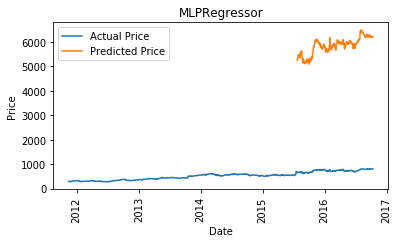

-11262.3664871


In [599]:
from sklearn import linear_model
from sklearn.metrics import r2_score
import sklearn
import inspect
def f():
    tscv = TimeSeriesSplit(n_splits=3)
    SEED = 100
    random_state = np.random.RandomState(SEED)
    
    for train_index, test_index in tscv.split(X):
        train_index=train_index.tolist()
        test_index = test_index.tolist()
        X_train ,X_test= X.iloc[train_index],X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        min_error = 10000000000
        print type(X_train)
        print (X_test.values)
        print y_train.isnull().any()
        #X_train.replace([np.inf, -np.inf], np.nan)
        #print X_train.isnull().values.any()
        error = []
        alp = [1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]
        fin_alpha = 0
        reg = fit_model(X_train,y_train,'r')
        reg = sklearn.neural_network.MLPRegressor()
        reg.fit(X_train,y_train)
        #reg = fit_gridModel(X_train,y_train,'Lasso')
        #print "Parameter 'alpha' is {} for the optimal model.".format(reg.get_params()['alpha'])
        print reg
        model_name = type(reg).__name__
    print len(X_test)
    print len(X_train)

    prediction = reg.predict(X_test)
    df = pd.Series(prediction.flatten(), index=y_test.index)
    print df.head()
    price = y_train.append(y_test)
    plot_prediction(price,df,model_name,ticker)
    p_l = map(lambda x:[x],prediction)
    #print MSE(np.array(p_l),y_test)
    print reg.score(X_test,y_test)
    #print r2_score(prediction,y_test)
    #     plt.title(model_name)
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.plot(price,label='Actual Price')
#     plt.plot(df, label='Predicted Price')
#     plt.legend(loc='upper left')
#     plt.show()
        
        #         for i in range(0, len(alp)):
#             regr = linear_model.Ridge(alpha=alp[i],random_state=random_state)
#             regr.fit(X_train, y_train)
#             predict = regr.predict(X_test)
#             mse = MSE(predict, y_test)
#             error.append(mse)
#             # print mse[0]
#             if (mse[0] < min_error):
#                 min_error = mse[0]
#                 fin_alpha = alp[i]

#         regr = linear_model.Ridge(alpha= fin_alpha,random_state=random_state)
#         regr.fit(X_train, y_train)
#         score = regr.score(X_test, y_test)
#         predict = regr.predict(X_test)
#         mse = MSE(predict, y_test)
#         print 'MSE22 '+' '+ str(mse[0])
#         df = pd.Series(predict.flatten(), index=y_test.index)
#         price = y_train.append(y_test)
#         plt.title('Ridge Regression on 2' )
#         plt.plot(price,label='actual price')
#         plt.plot(df, label='predicted price')
#         plt.legend(loc='lower right')
#         plt.xlabel('Dates')
#         plt.ylabel('Price')
#         #plt.show()
#         directory = './ridge2/'
#         if not os.path.exists(directory):
#             os.makedirs(directory)
#         plt.savefig(directory+ 'a2.png')
#         plt.close()
#         print(inspect.currentframe().f_code.co_name)
f()

In [525]:
len(dates)/30

60

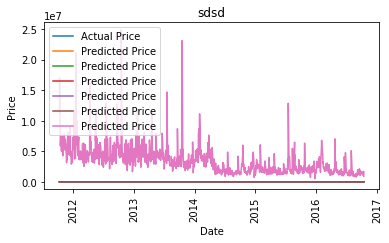

In [218]:
plot_prediction(Y,df,'sdsd',ticker)

In [150]:
functions_list

[('MSE', <function Regressors.MSE>),
 ('adaboost_regressor', <function Regressors.adaboost_regressor>),
 ('elasticnet_regressor', <function Regressors.elasticnet_regressor>),
 ('lasso_regressor', <function Regressors.lasso_regressor>),
 ('linear_regressor', <function Regressors.linear_regressor>),
 ('poly_regressor', <function Regressors.poly_regressor>),
 ('randomforest_regressor', <function Regressors.randomforest_regressor>),
 ('ridge_regressor', <function Regressors.ridge_regressor>),
 ('svm_regressor', <function Regressors.svm_regressor>)]

In [514]:
np.logspace(0,10,num=1e-5, base=10, endpoint=False)

array([], dtype=float64)